In [1]:
from __future__ import division
%pylab inline
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
#mport seaborn as sns
#sns.set()
pd.options.display.max_colwidth = 128
pylab.rcParams['figure.figsize'] = 12, 5
# d = pd.read_csv('...', parse_dates=['date'])
# pd.to_datetime(d['timestamp'], unit='s')
# with mpl.rc_context({"figure.figsize": (5, 5)}):
# with mpl.rc_context({"lines.linewidth": 2, "lines.color": "r"}):
# plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
# ax.set_xlabel('x label')

Populating the interactive namespace from numpy and matplotlib


In [2]:
from skyfield import api
load = api.Loader('../data')
ts = load.timescale(builtin=True)
eph = load('de421.bsp')
sun = eph['sun']
earth = eph['earth']

In [3]:
t_comet = ts.utc(2020, 7, range(17, 27))
t = t_comet[len(t_comet) // 2]  # middle date

In [4]:
from skyfield.data import mpc

with load.open(mpc.COMET_URL) as f:
    comets = mpc.load_comets_dataframe(f)

comets = comets.set_index('designation', drop=False)
row = comets.loc['C/2020 F3 (NEOWISE)']

In [5]:
from skyfield.constants import GM_SUN_Pitjeva_2005_km3_s2 as GM_SUN

comet = sun + mpc.comet_orbit(row, ts, GM_SUN)
center = earth.at(t).observe(comet)

In [6]:
from skyfield.api import Star
from skyfield.data import hipparcos

In [53]:
from skyfield.projections import build_stereographic_projection
proj = build_stereographic_projection(center)

In [54]:
with load.open(hipparcos.URL) as f:
    stars = hipparcos.load_dataframe(f)

In [55]:
star_positions = earth.at(t).observe(Star.from_dataframe(stars))
stars['x'], stars['y'] = proj(star_positions)

In [56]:
limiting_magnitude = 6.5
bright_stars = (stars.magnitude <= limiting_magnitude)

In [57]:
comet_x, comet_y = proj(earth.at(t_comet).observe(comet))
print(comet_x, comet_y)

[ 0.15500351  0.12487192  0.09415085  0.06298742  0.03154536  0.
 -0.03146817 -0.06268067 -0.09346815 -0.12367671] [ 4.36914984e-02  3.62581155e-02  2.80757650e-02  1.92390628e-02
  9.84665625e-03  2.77555756e-17 -1.01985406e-02 -2.06480548e-02
 -3.12516353e-02 -4.19187999e-02]


In [98]:
# = 'https://raw.githubusercontent.com/Stellarium/stellarium/master/skycultures/western_SnT/constellationship.fab'
from skyfield.data.stellarium import parse_constellations

url = 'https://raw.githubusercontent.com/Stellarium/stellarium/master/skycultures/western_SnT/constellationship.fab'
with load.open(url) as f:
    constellations = parse_constellations(f)

edges_star1 = [star1 for name, edges in constellations for star1, star2 in edges]
edges_star2 = [star2 for name, edges in constellations for star1, star2 in edges]

np.array([stars['x'].loc[edges_star1], stars['y'].loc[edges_star1]])
xy1 = stars[['x', 'y']].loc[edges_star1].values
xy2 = stars[['x', 'y']].loc[edges_star2].values
lines_xy = np.rollaxis(array([xy1, xy2]), 1)

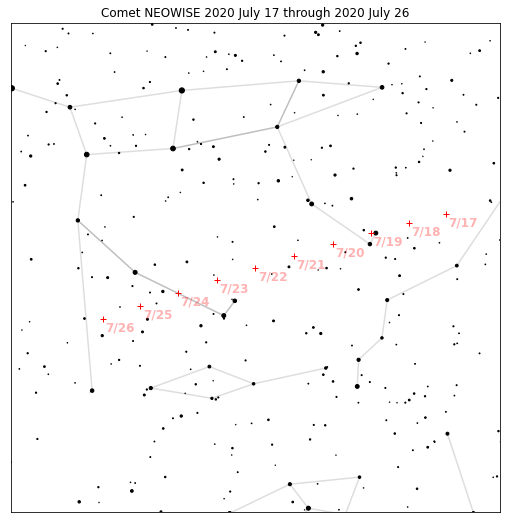

In [94]:
fig, ax = plt.subplots(figsize=[9, 9])

from matplotlib.collections import LineCollection
from skyfield.api import tau

field_of_view_degrees = 45.0

line_collection = LineCollection(lines_xy, colors='#0002')
ax.add_collection(line_collection)

marker_size = (0.5 + limiting_magnitude - stars.magnitude[bright_stars]) ** 2.0
ax.scatter(stars['x'][bright_stars], stars['y'][bright_stars], s=marker_size, color='k')
#ax.scatter(comet_x, comet_y, s=100, color='b')
comet_color = '#f00'
ax.plot(comet_x, comet_y, '+', c=comet_color, zorder=3)
offset = 0.002
for xi, yi, tstr in zip(comet_x, comet_y, t_comet.utc_strftime('%-m/%d')):
    text = ax.text(xi + offset, yi - offset, tstr, color=comet_color, ha='left', va='top', fontsize=12,
           weight='bold')
    text.set_alpha(0.3)

ax.set_title('Comet NEOWISE {} through {}'.format(
    t_comet[0].utc_strftime('%Y %B %d'),
    t_comet[-1].utc_strftime('%Y %B %d'),
))
ax.set_aspect(1.0)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

angle = pi - field_of_view_degrees / 360.0 * pi
limit = sin(angle) / (1.0 - cos(angle))
ax.set_xlim(-limit, limit)
ax.set_ylim(-limit, limit)
None